In [2]:
#Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.dates as dt

%matplotlib inline

from scipy.stats import norm, skew #for some statistics
from scipy import stats #qqplot
import statsmodels.api as sm #for decomposing the trends, seasonality etc.

from matplotlib import rcParams

from statsmodels.tsa.statespace.sarimax import SARIMAX #the big daddy

In [3]:
df  = pd.read_csv('RoomsDemand.csv',parse_dates = {'Date' : [ "Month", "Year"]})
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
df.head()

,Date,FX,Demand,ADR,Country
0,2012-01-01,1.550,10747730,93.014,UK
1,2012-02-01,1.580,11334574,94.967,UK
2,2012-03-01,1.580,13157453,97.458,UK
3,2012-04-01,1.600,13078222,97.899,UK
4,2012-05-01,1.590,14307757,102.779,UK


In [5]:
# Check any number of columns with NaN
print(df.isnull().any().sum(), ' / ', len(df.columns))
# Check any number of data points with NaN
print(df.isnull().any(axis=1).sum(), ' / ', len(df))


0  /  5
0  /  455


In [6]:
#Lets check where these nulls are.
print (df.isna().sum())
print ('Null to Dataset Ratio in Dates: ',df.isnull().sum()[3]/df.shape[0]*100)
#There are missing values in Dates.

Date       0
FX         0
Demand     0
ADR        0
Country    0
dtype: int64
Null to Dataset Ratio in Dates:  0.0


In [7]:
df.dtypes

Date       datetime64[ns]
FX                float64
Demand              int64
ADR               float64
Country            object
dtype: object

In [8]:
#checking number of columns and rows
df.shape

(455, 5)

In [9]:
# Check any number of columns with NaN
print(df.isnull().any().sum(), ' / ', len(df.columns))
# Check any number of data points with NaN
print(df.isnull().any(axis=1).sum(), ' / ', len(df))

0  /  5
0  /  455


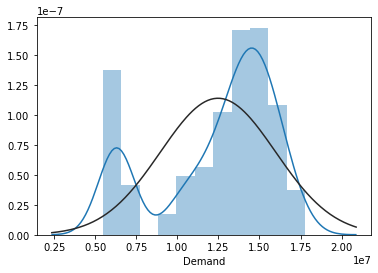

In [10]:
#seems like we dont have any column or row with null value
# lets have a look at distribution plot of Order_Demand
sns.distplot(df['Demand'], fit=norm)

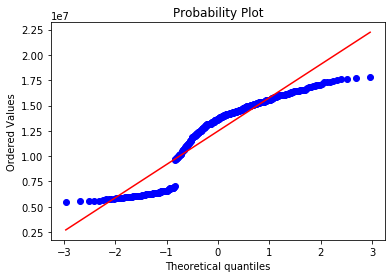

In [11]:
#Get the QQ-plot
fig = plt.figure()
res = stats.probplot(df['Demand'], plot=plt)
plt.show()

In [12]:
#The data is less skewed but is bimodal and not Normally distributed. However, since we are running ARIMA it should be fine
df['Demand'].skew()

-0.798823202678367

In [14]:
#Number of data points by each country.
df['Country'].value_counts().sort_values(ascending = False)


UK           91
Australia    91
Japan        91
Germany      91
France       91
Name: Country, dtype: int64

In [15]:
#Demand of rooms created by each country.
df.groupby('Country').sum().sort_values('Demand', ascending = False)

,FX,Demand,ADR
Country,,,
Japan,0.877,1397217687,10908.974
UK,132.670,1337408427,10041.933
Germany,109.490,1206152358,10125.547
France,109.490,1163011416,8997.582
Australia,75.970,573371668,11867.081


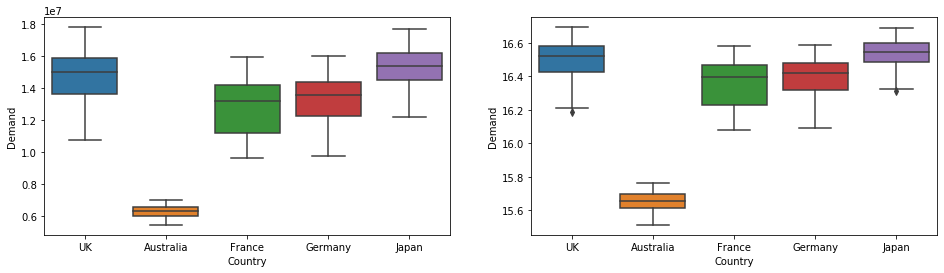

In [16]:
#Lets check the orders by warehouse.

#Checking with Boxplots
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 16,4
f, axes = plt.subplots(1, 2)
#Regular Data
fig3 = sns.boxplot( df['Country'],df['Demand'], ax = axes[0])
#Data with Log Transformation
fig4 = sns.boxplot( df['Country'], np.log1p(df['Demand']),ax = axes[1])

del fig3, fig4

In [19]:
df = df.groupby('Date')['Demand'].sum().reset_index()
#This gives us the total orders placed on each day.

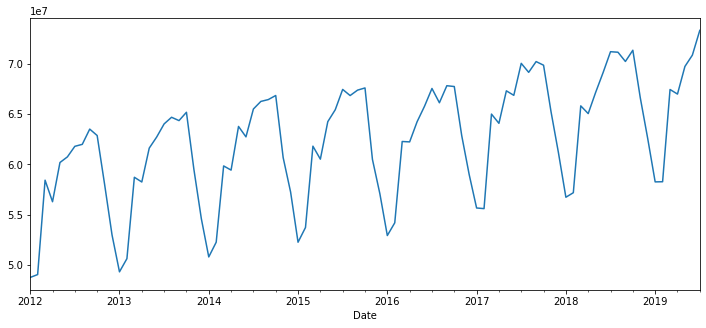

In [20]:
#Index the date
df = df.set_index('Date')
df.index #Lets check the index

y = df['Demand'].resample('MS').mean()
y.plot(figsize=(12,5))
plt.show()

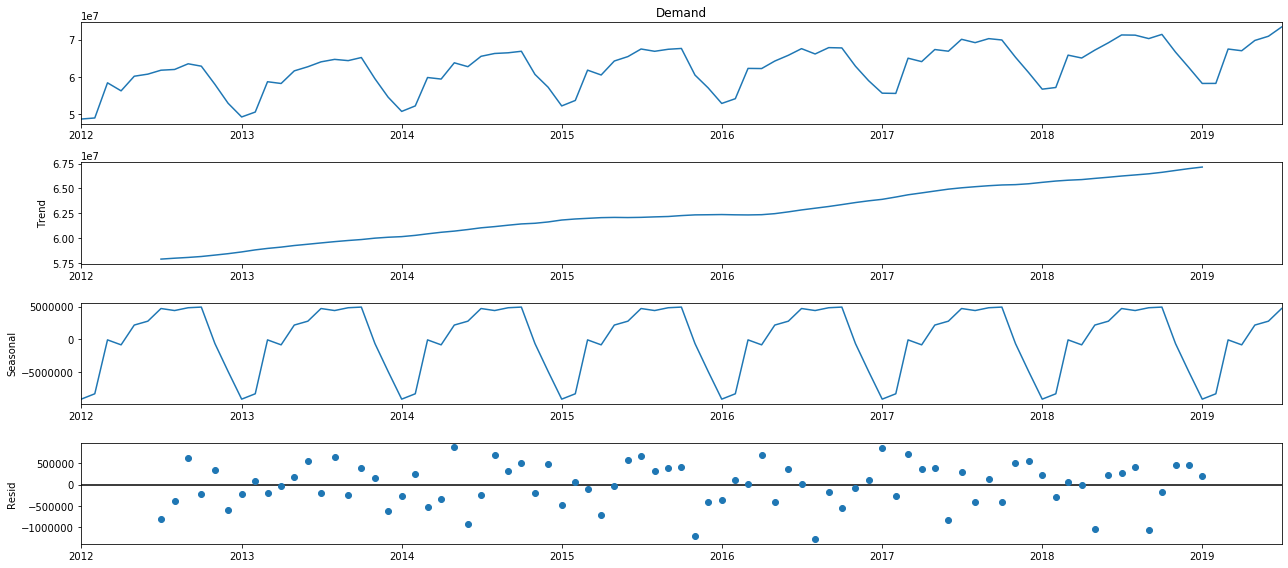

In [21]:
#The best part about time series data and decomposition is that you can break down the data into the following:
#Time Series Decomposition. 
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

#Takeaway: The rooms bookings are always lowest at the starting and ending of every year. 
#The observed trend shows that number of rooms booked have been increasing continiously since 2012.


In [22]:
#Grid Search

#Since ARIMA has hyper params that can be tuned, the objective here is to find the best params using Grid Search.

#Sample params for seasonal arima. (SARIMAX).

#For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function 
#from the statsmodels module and assess its overall quality.

import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [23]:
#Get the best params for the data. Choose the lowest AIC.

# The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a 
# given set of data. 
# AIC measures how well a model fits the data while taking into account the overall complexity of the model.
# Large AIC: Model fits very well using a lot of features.
# Small AIC: Model fits similar fit but using lesser features. 
# Hence LOWER THE AIC, the better it is.

#The code tests the given params using sarimax and outputs the AIC scores.

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:3489.3781938688726
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2977.481737284064
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2459.611298666462
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2079.747642320597
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2389.486928478265
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2360.4544622611
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2083.9661965149503
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2052.944020944604
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:3388.5224892430133
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3185.4971288766787
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2405.74168598855
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2028.4738578620666
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2988.751239302947
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2915.2369119850555
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2091.3216157325355
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2021.480879974318
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2946.0073869890584
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2500.

c:\users\satyam.anand\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:175764713.6256681
SARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:2342.087322780168
SARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:1962.4120753596649
SARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:2506.935379730444
SARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2476.906812677334
SARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:1991.572804042471
SARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:1964.410178249087
SARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:2944.8829132544793
SARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:2501.621104121274
SARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:2316.5626211669305
SARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:1958.4916509154818
SARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:2477.1150984652804
SARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:2479.1125684987683
SARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:1954.0500758654175
SARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:1956.0280014462078
SARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:2907.8827780446386
SARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:2467.8969920678337
SARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:

In [24]:
#Fit the model with the best params.
#ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1924.0346632592104


#The above output suggests that ARIMA(1, 1, 1)x(1, 1, 1, 12) yields the lowest AIC value: 1924.0346632592104
#Therefore we should consider this to be optimal option.

from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3740      0.212     -1.768      0.077      -0.789       0.041
ma.L1         -0.2895      0.124     -2.328      0.020      -0.533      -0.046
ar.S.L12      -0.3923      0.151     -2.598      0.009      -0.688      -0.096
ma.S.L12       0.0121      0.101      0.120      0.904      -0.185       0.209
sigma2      6.204e+11   5.92e-14   1.05e+25      0.000     6.2e+11     6.2e+11


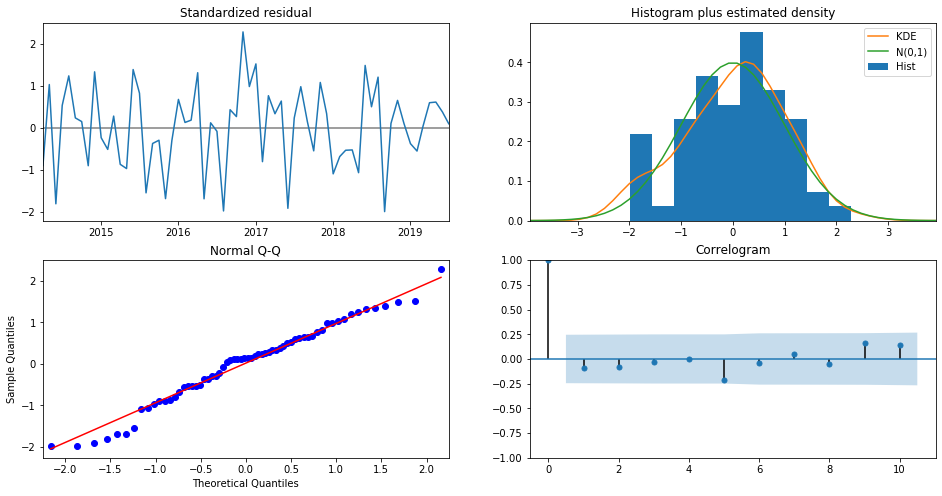

In [25]:
#Interpreting the table:

#coeff: Shows weight/impotance how each feature impacts the time series. Pvalue: Shows the significance of each feature weight. Can test hypothesis using this. If p value is <.05 then they are statitically significant.

#Refresher on null hyp and pvalues. By default we take the null hyp as 'there is no relationship bw them' If p value < .05 (significance level) then you reject the Null Hypthesis If p value > .05 , then you fail to reject the Null Hypothesis.

#So, if the p-value is < .05 then there is a relationship between the response and predictor. Hence, significant.


#Plotting the diagnostics.

#The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.
results.plot_diagnostics(figsize=(16, 8))
plt.show()

#What to look for?
#1. Residuals SHOULD be Normally Distributed ; Check
#Top Right: The (orange colored) KDE line should be closely matched with green colored N(0,1) line. This is the standard notation
#for normal distribution with mean 0 and sd 1.
#Bottom Left: The qq plot shows the ordered distribution of residuals (blue dots) follows the linear trend of the samples 
#taken from a standard normal distribution with N(0, 1). 

#2. #Residuals are not correlated; Check
#Top Left: The standard residuals don’t display any obvious seasonality and appear to be white noise. 
#Bottom Right: The autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have 
#low correlation with its own lagged versions.

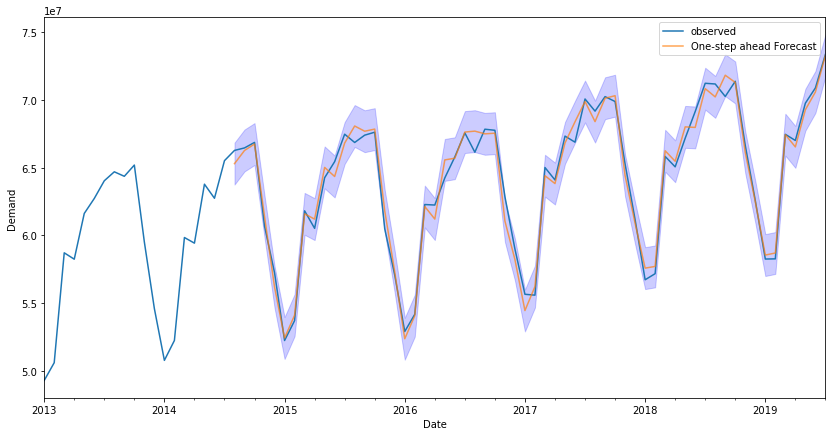

In [31]:
#Lets get the predictions and confidence interval for those predictions.
#Get the predictions. The forecasts start from the 1st of Aug 2014 but the previous line shows how it fits to the data.
pred = results.get_prediction(start=pd.to_datetime('2014-08-01'), dynamic=False) #false is when using the entire history.
#Confidence interval.
pred_ci = pred.conf_int()

#Plotting real and forecasted values.
ax = y['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='blue', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Demand')
plt.legend()
plt.show()

#Takeaway: The forecats seems to be fitting well to the data. The Blue/purple thicker plot shows the confidence level in the forecasts. 

In [32]:
#Getting the mean squared error (average error of forecasts).
y_forecasted = pred.predicted_mean
y_truth = y['2016-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE {}'.format(round(mse, 2)))

#Smaller the better.

MSE 559521915225.8


In [33]:
print('RMSE: {}'.format(round(np.sqrt(mse), 2)))

RMSE: 748011.98


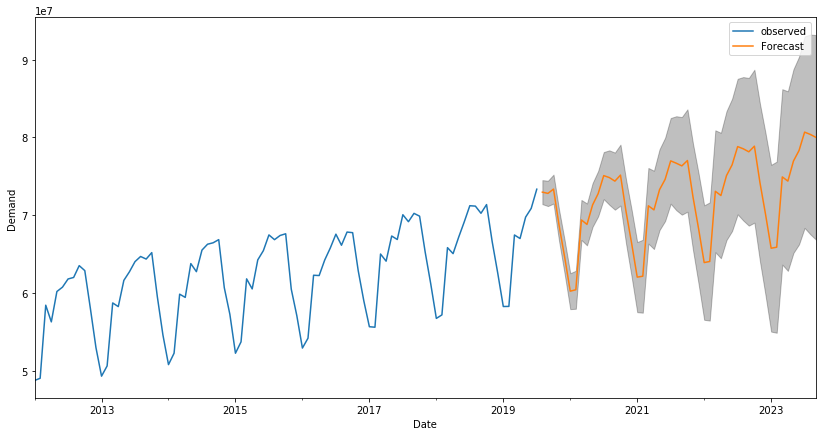

In [34]:
#The time can be changed using steps.
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Demand')
plt.legend()
plt.show()

#Far out values are naturally more prone to variance. The grey area is the confidence we have in the predictions.